In [1]:
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
import tensorflow.compat.v1 as tf
from scipy.ndimage.interpolation import rotate
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Mounting the Google Drive for loadring the files (if you are using your local machine, don't run the cell below)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading datas

In [3]:
train_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/Q1_train.csv'
test_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/Q1_test.csv'
data_train = []
data_test = []
with open(train_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_train.append(row)
with open(test_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_test.append(row)

data_train = np.array(data_train[1:], dtype=np.float32)
data_test = np.array(data_test[1:], dtype=np.float32)



In [4]:
num_of_train_samples = len(data_train[:, 1])
validation_set_size = 0.8

x_train = data_train[0:int(validation_set_size*num_of_train_samples), 1:]
y_train_cls = data_train[0:int(validation_set_size*num_of_train_samples), 0]

for i in range(len(y_train_cls)):
  if y_train_cls[i]>=9:
    y_train_cls[i] = y_train_cls[i]-1

x_validation = data_train[int(validation_set_size*num_of_train_samples)+1:, 1:]
y_validation_cls = data_train[int(validation_set_size*num_of_train_samples)+1:, 0]

for i in range(len(y_validation_cls)):
  if y_validation_cls[i]>=9:
    y_validation_cls[i] = y_validation_cls[i]-1


x_test = data_test[:,1:]
y_test_cls = data_test[:,0]

for i in range(len(y_test_cls)):
  if y_test_cls[i]>=9:
    y_test_cls[i] = y_test_cls[i]-1

img_size_flat = len(x_train[0])
img_shape = (int(np.sqrt(img_size_flat)), int(np.sqrt(img_size_flat)))
alphabets =  'ABCDEFGHIKLMNOPQRSTUVWXY'
num_classes = len(alphabets)

In [5]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test_cls.reshape(-1, 1)).toarray()
y_validation = enc.fit_transform(y_validation_cls.reshape(-1, 1)).toarray()

## Part a - showing some of the the images

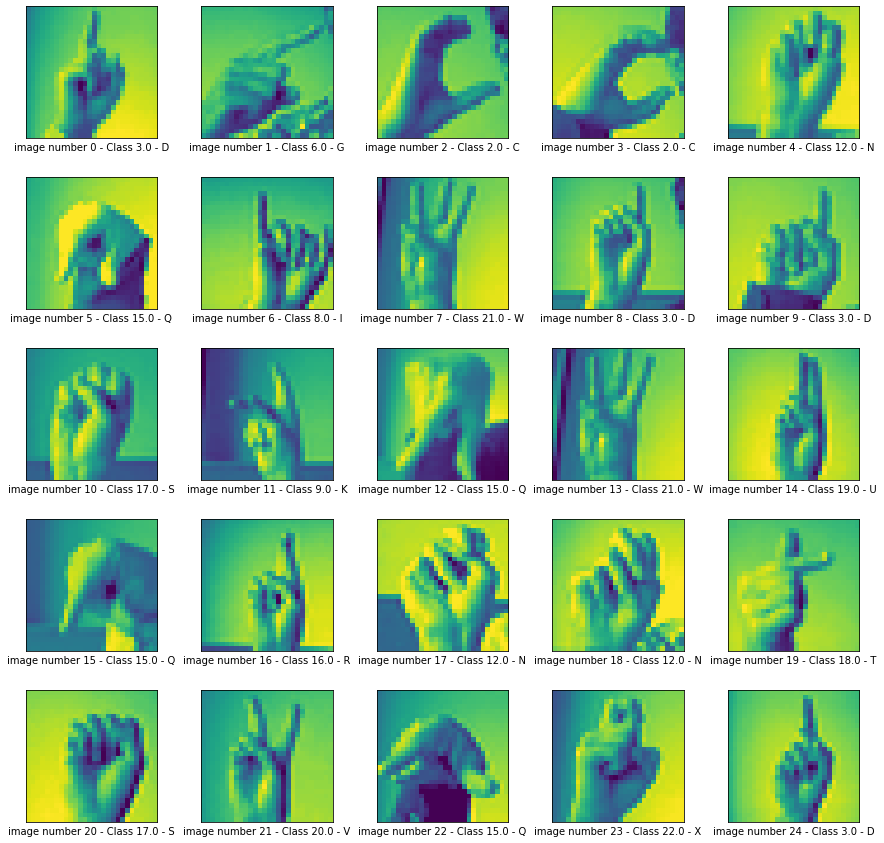

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axes.flat):
    image = x_train[i].reshape(img_shape)
    # Set the label for the sub-plot.
    ax.set_xlabel("image number {0} - Class {1} - {2}".format(i, y_train_cls[i], alphabets[int(y_train_cls[i])]))
    # Plot the image.
    ax.imshow(image)
    # Remove ticks from each sub-plot.
    ax.set_xticks([])
    ax.set_yticks([])

## Part b - Designing an MLP

#### SGD 

In [ ]:
tf.reset_default_graph()

learning_rate = 0.1
batch_size = 50

n_neurons_in_h1 = int(img_size_flat)
n_neurons_in_h2 = int(img_size_flat)
n_neurons_in_h3 = int(img_size_flat)
# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
# weights_1 = tf.Variable(tf.random_normal([img_size_flat, n_neurons_in_h1],mean=0,stddev=1/np.sqrt(img_size_flat)))
# weights_2 = tf.Variable(tf.random_normal([n_neurons_in_h1, n_neurons_in_h2],mean=0,stddev=1/np.sqrt(n_neurons_in_h1)))
# weights_3 = tf.Variable(tf.random_normal([n_neurons_in_h2, n_neurons_in_h3],mean=0,stddev=1/np.sqrt(n_neurons_in_h2)))
weights_out = tf.Variable(tf.random_normal([n_neurons_in_h3, num_classes],mean=0,stddev=1/np.sqrt(n_neurons_in_h3)))
# network biases
# biases_1 = tf.Variable(tf.random_normal([n_neurons_in_h1],mean=0,stddev=1/np.sqrt(n_neurons_in_h1)))
# biases_2 = tf.Variable(tf.random_normal([n_neurons_in_h2],mean=0,stddev=1/np.sqrt(n_neurons_in_h2)))
# biases_3 = tf.Variable(tf.random_normal([n_neurons_in_h3],mean=0,stddev=1/np.sqrt(n_neurons_in_h3)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

In [ ]:
y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(y_pred_act, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb]}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

In [ ]:
def optimize(num_iterations, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    Test_Accuracy = np.zeros([num_iterations])
    loss = np.zeros([num_iterations])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    for i in range(num_iterations):
        
        indexes = random.sample(range(0, x_train.shape[0]), batch_size) 
        x_batch = x_train[indexes, :]
        y_true_batch = y_train[indexes]
        feed_dict = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict) 
        [accs_train[i], loss[i]]= calcAccuracy(feed_dict_train)
        [accs_validation[i], loss[i]]= calcAccuracy(feed_dict_validation)
        Test_Accuracy[i] = session.run(accuracy, feed_dict=feed_dict_test)
    return accs_train, accs_validation, Test_Accuracy, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.imshow(np.uint8(abs(w)), vmin=w_min, vmax=w_max, cmap='seismic')
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

def print_confusion_matrix():
    cls_true = feed_dict_train[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_train)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

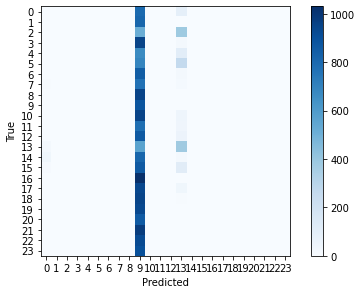

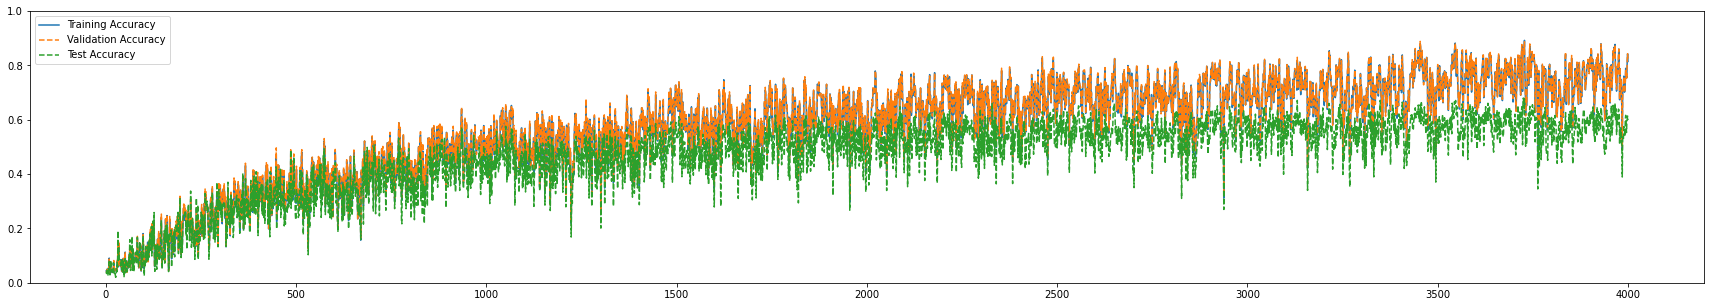

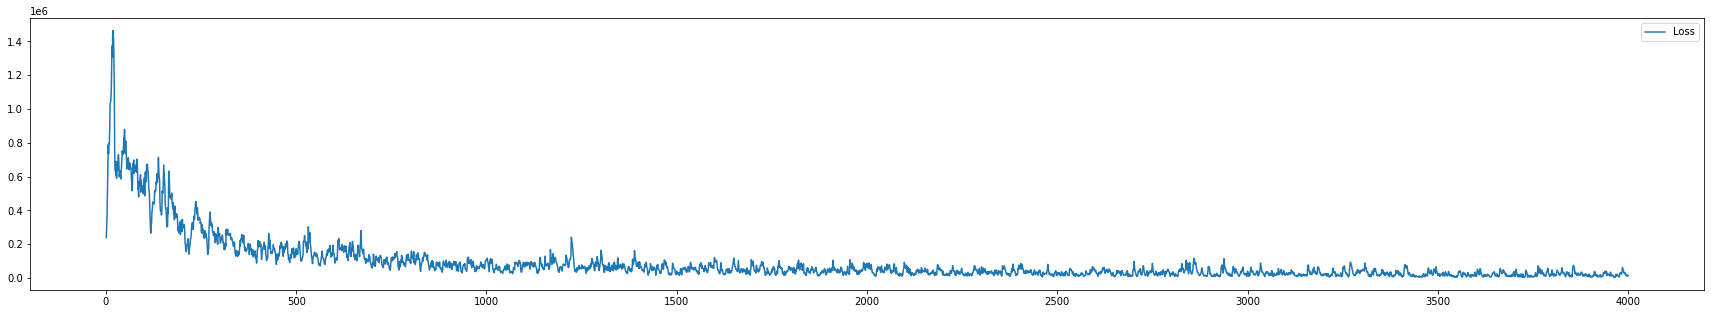

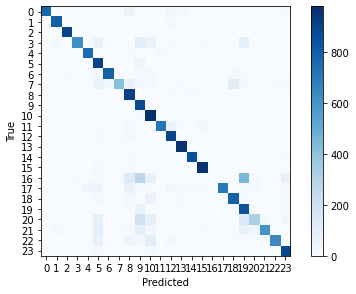

In [ ]:
# plot_weights(weights_1)
# # plot_weights(weights_2)
# plot_weights(weights_out)
print_confusion_matrix()
num_iterations = 4000
[accs_train, accs_validation, Test_Accuracy, loss] = optimize(num_iterations, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), Test_Accuracy, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), loss, label='Loss')
plt.legend()
plt.show()

# plot_weights(weights_1)
# # plot_weights(weights_2)
# plot_weights(weights_out)
print_confusion_matrix()

In [ ]:
Test_Accuracy = session.run(accuracy, feed_dict=feed_dict_test)
print(Test_Accuracy)

0.5909915


#### ADAM

In [ ]:
tf.reset_default_graph()

learning_rate = 0.1
batch_size = 50

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(n_neurons_in_h3)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

In [ ]:
beta1 = 0.9
beta2 = 0.999

y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(y_pred_act, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb]}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

In [ ]:
def optimize(num_iterations, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    Test_Accuracy = np.zeros([num_iterations])
    loss = np.zeros([num_iterations])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    for i in range(num_iterations):
        
        indexes = random.sample(range(0, x_train.shape[0]), batch_size) 
        x_batch = x_train[indexes, :]
        y_true_batch = y_train[indexes]
        feed_dict = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict) 
        [accs_train[i], loss[i]]= calcAccuracy(feed_dict_train)
        [accs_validation[i], loss[i]]= calcAccuracy(feed_dict_validation)
        Test_Accuracy[i] = session.run(accuracy, feed_dict=feed_dict_test)
    return accs_train, accs_validation, Test_Accuracy, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.imshow(np.uint8(abs(w)), vmin=w_min, vmax=w_max, cmap='seismic')
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

def print_confusion_matrix():
    cls_true = feed_dict_train[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_train)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

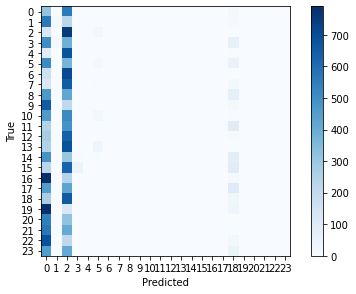

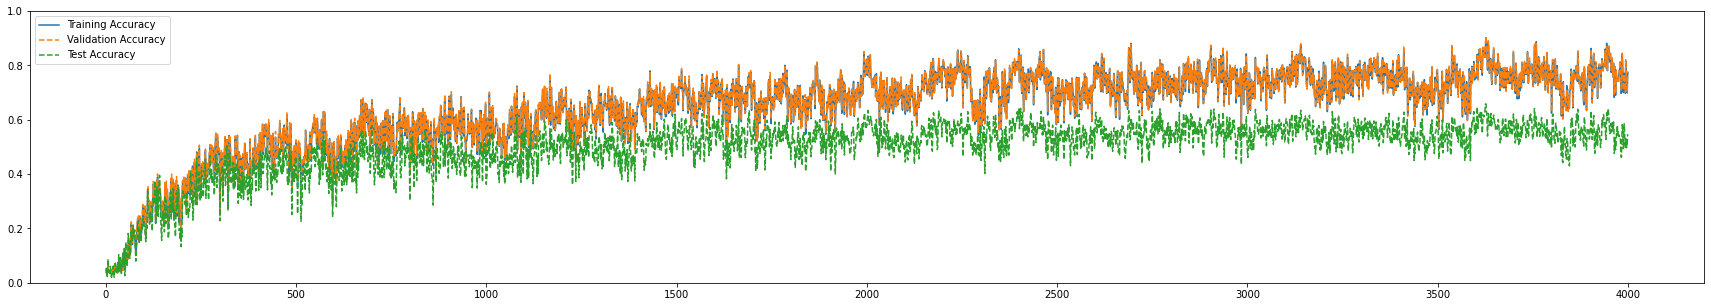

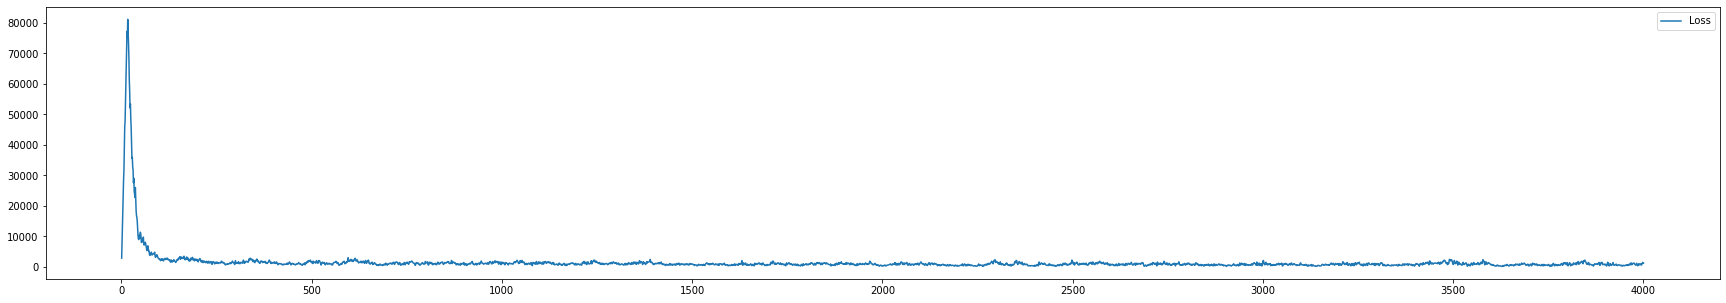

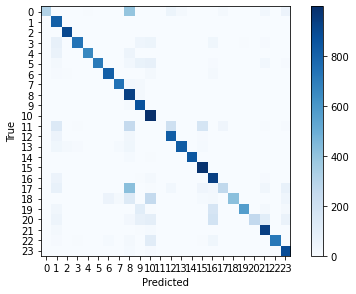

In [ ]:
# plot_weights(weights_1)
# # plot_weights(weights_2)
# plot_weights(weights_out)
print_confusion_matrix()
num_iterations = 4000
[accs_train, accs_validation, Test_Accuracy, loss] = optimize(num_iterations, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), Test_Accuracy, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), loss, label='Loss')
plt.legend()
plt.show()

# plot_weights(weights_1)
# # plot_weights(weights_2)
# plot_weights(weights_out)
print_confusion_matrix()

In [ ]:
Test_Accuracy = session.run(accuracy, feed_dict=feed_dict_test)
print(Test_Accuracy)

0.5426021


## Part c

## Part d - Adding Dropout

In [ ]:
tf.reset_default_graph()

learning_rate = 0.5
batch_size = 50

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(n_neurons_in_h3)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)

In [ ]:
y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act)
y_pred_cls = tf.argmax(y_pred_act_DO, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                   keep_prob:1}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                   keep_prob:1}

In [ ]:
def optimize(num_iterations, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    # Test_Accuracy = np.zeros([num_iterations])
    loss = np.zeros([num_iterations])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    for i in range(num_iterations):
        
        indexes = random.sample(range(0, x_train.shape[0]), batch_size) 
        x_batch = x_train[indexes, :]
        y_true_batch = y_train[indexes]
        feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:0.5}

        session.run(optimizer, feed_dict=feed_dict) 
        [accs_train[i], loss[i]]= calcAccuracy(feed_dict_train)
        [accs_validation[i], loss[i]]= calcAccuracy(feed_dict_validation)
        # Test_Accuracy[i] = session.run(accuracy, feed_dict=feed_dict_test)
    return accs_train, accs_validation, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.imshow(np.uint8(abs(w)), vmin=w_min, vmax=w_max, cmap='seismic')
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

def print_confusion_matrix():
    cls_true = feed_dict_train[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_train)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

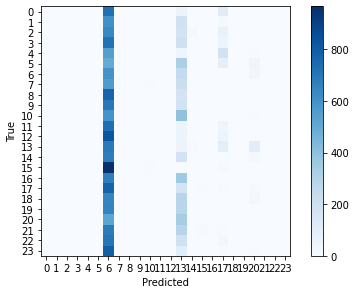

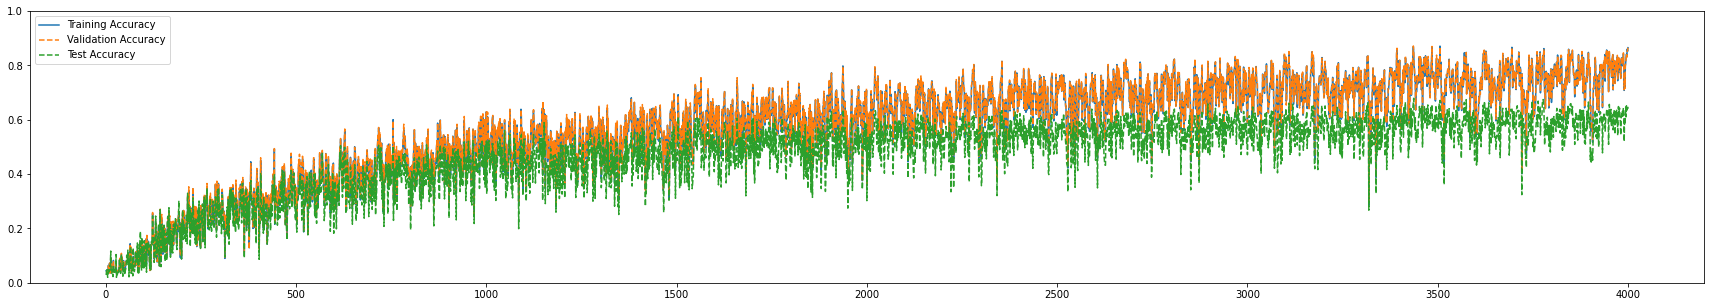

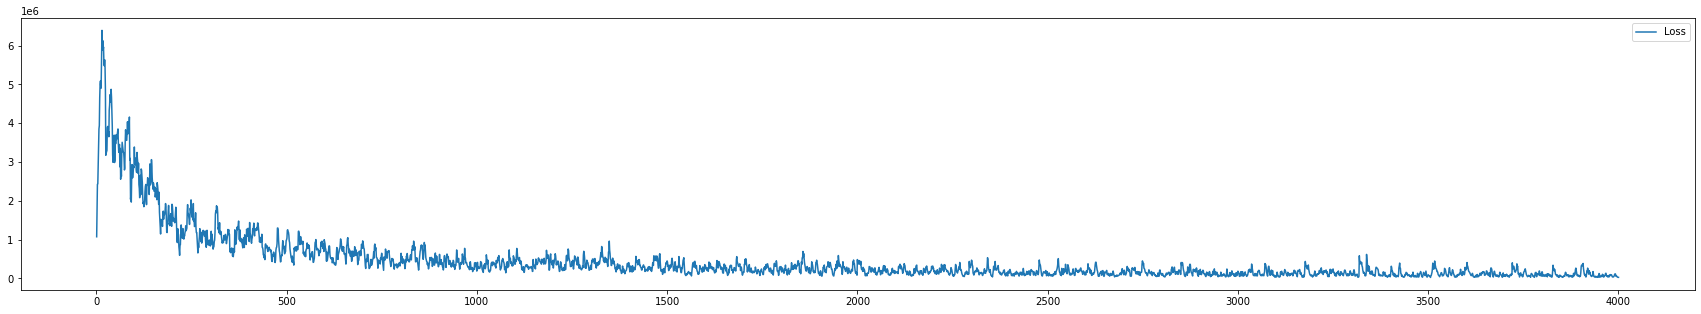

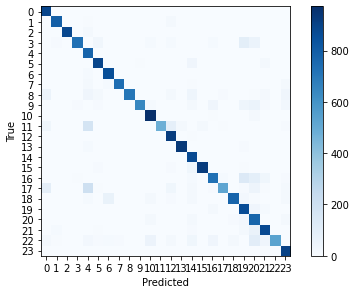

In [ ]:
# plot_weights(weights_1)
# # plot_weights(weights_2)
# plot_weights(weights_out)
print_confusion_matrix()
num_iterations = 4000
[accs_train, accs_validation, Test_Accuracy, loss] = optimize(num_iterations, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), Test_Accuracy, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), loss, label='Loss')
plt.legend()
plt.show()

# plot_weights(weights_1)
# # plot_weights(weights_2)
# plot_weights(weights_out)
print_confusion_matrix()

In [ ]:
Test_Accuracy = session.run(accuracy, feed_dict=feed_dict_test)
print(Test_Accuracy)

0.6476084


## Part e - Adding more layers

#### SGD

##### Network graph

In [70]:
tf.reset_default_graph()

learning_rate = 0.005
batch_size = 100

hl1_n = int(2*img_size_flat)
hl2_n = int(img_size_flat)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_out = tf.Variable(tf.random_normal([hl2_n, num_classes],mean=0,stddev=1/np.sqrt(hl2_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)




y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.sigmoid(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act)


y_2 = tf.matmul(y_1_act_DO, weights_2) + biases_2
y_2_act = tf.nn.sigmoid(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act)

y_pred = tf.matmul(y_2_act_DO, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act_DO, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}


/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


##### Helper Functions

In [71]:
def optimize(num_iterations, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    # Test_Accuracy = np.zeros([num_iterations])
    loss = np.zeros([num_iterations])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    next_line = 0
    list_of_samples = [i for i in range(0, x_train.shape[0])]
    for i in range(num_iterations):
        if np.mod(i,100)==0:
          if np.mod(next_line,4) == 1:
            print('\n')
          Test_Accuracy = session.run(accuracy, feed_dict=feed_dict_test)
          next_line = next_line+1          
          print("| Iteration {0} - Test Acc = {1:.2f}".format(i, Test_Accuracy) , sep=' ', end='', flush=False)
        if len(list_of_samples) < batch_size:
          list_of_samples = [i for i in range(0, x_train.shape[0])]
        indexes = random.sample(list_of_samples, batch_size)
        for j in indexes:
          list_of_samples.remove(j)
        x_batch = x_train[indexes, :]
        y_true_batch = y_train[indexes]
        feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:0.5}

        session.run(optimizer, feed_dict=feed_dict) 
        [accs_train[i], loss[i]]= calcAccuracy(feed_dict_train)
        [accs_validation[i], loss[i]]= calcAccuracy(feed_dict_validation)
        # Test_Accuracy[i] = session.run(accuracy, feed_dict=feed_dict_test)
    return accs_train, accs_validation, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.imshow(np.uint8(abs(w)), vmin=w_min, vmax=w_max, cmap='seismic')
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

def print_confusion_matrix():
    cls_true = feed_dict_train[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_train)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

##### Runing Optimization

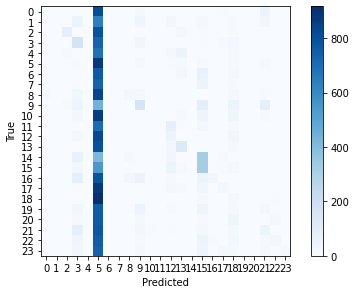

| Iteration 0 - Test Acc = 0.06

| Iteration 100 - Test Acc = 0.10| Iteration 200 - Test Acc = 0.24| Iteration 300 - Test Acc = 0.24| Iteration 400 - Test Acc = 0.24

| Iteration 500 - Test Acc = 0.20| Iteration 600 - Test Acc = 0.31| Iteration 700 - Test Acc = 0.31| Iteration 800 - Test Acc = 0.32

| Iteration 900 - Test Acc = 0.36| Iteration 1000 - Test Acc = 0.28| Iteration 1100 - Test Acc = 0.35| Iteration 1200 - Test Acc = 0.34

| Iteration 1300 - Test Acc = 0.38| Iteration 1400 - Test Acc = 0.37| Iteration 1500 - Test Acc = 0.38| Iteration 1600 - Test Acc = 0.40

| Iteration 1700 - Test Acc = 0.41| Iteration 1800 - Test Acc = 0.42| Iteration 1900 - Test Acc = 0.43| Iteration 2000 - Test Acc = 0.44

| Iteration 2100 - Test Acc = 0.47| Iteration 2200 - Test Acc = 0.49| Iteration 2300 - Test Acc = 0.48| Iteration 2400 - Test Acc = 0.48

| Iteration 2500 - Test Acc = 0.51| Iteration 2600 - Test Acc = 0.49| Iteration 2700 - Test Acc = 0.52| Iteration 2800 - Test Acc = 0.51

| Iteratio

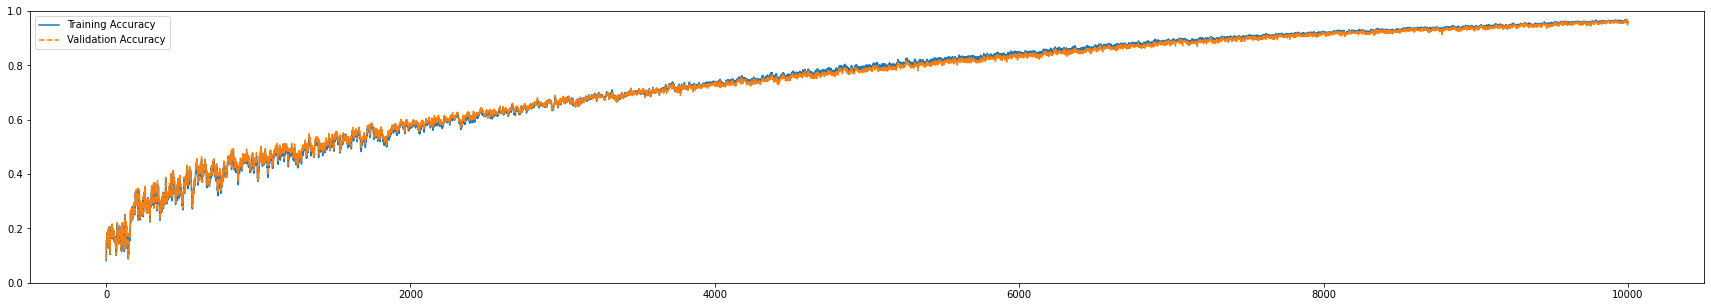

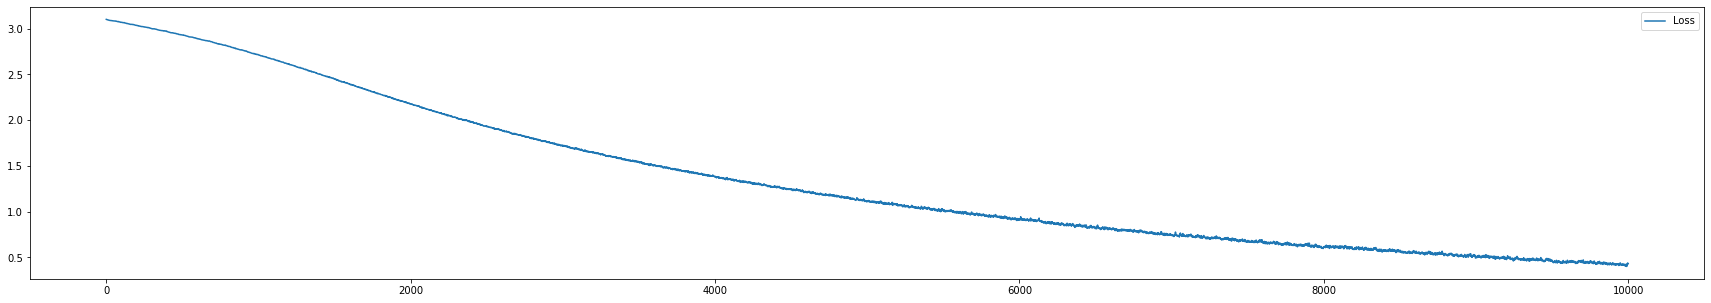

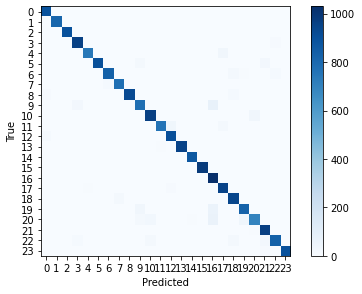

In [73]:
print_confusion_matrix()
num_iterations = 10000
[accs_train, accs_validation, loss] = optimize(num_iterations, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, '--', label='Validation Accuracy')

plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), loss, label='Loss')
plt.legend()
plt.show()

print_confusion_matrix()

#### ADAM

##### Network graph

In [64]:
tf.reset_default_graph()
beta1 = 0.85
beta2 = 0.95
learning_rate = 3e-5
batch_size = 100

hl1_n = int(2*img_size_flat)
hl2_n = int(img_size_flat)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_out = tf.Variable(tf.random_normal([hl2_n, num_classes],mean=0,stddev=1/np.sqrt(hl2_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)




y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.sigmoid(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act)


y_2 = tf.matmul(y_1_act_DO, weights_2) + biases_2
y_2_act = tf.nn.sigmoid(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act)

y_pred = tf.matmul(y_2_act_DO, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act_DO, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)
# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


##### Helper Functions

In [66]:
def optimize(num_iterations, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    # Test_Accuracy = np.zeros([num_iterations])
    loss = np.zeros([num_iterations])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    next_line = 0
    list_of_samples = [i for i in range(0, x_train.shape[0])]
    for i in range(num_iterations):
        if np.mod(i,100)==0:
          if np.mod(next_line,4) == 1:
            print('\n')
          Test_Accuracy = session.run(accuracy, feed_dict=feed_dict_test)
          next_line = next_line+1          
          print("| Iteration {0} - Test Acc = {1:.2f}".format(i, Test_Accuracy) , sep=' ', end='', flush=False)
        if len(list_of_samples) < batch_size:
          list_of_samples = [i for i in range(0, x_train.shape[0])]
        indexes = random.sample(list_of_samples, batch_size)
        for j in indexes:
          list_of_samples.remove(j)
        x_batch = x_train[indexes, :]
        y_true_batch = y_train[indexes]
        feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:0.5}

        session.run(optimizer, feed_dict=feed_dict) 
        [accs_train[i], loss[i]]= calcAccuracy(feed_dict_train)
        [accs_validation[i], loss[i]]= calcAccuracy(feed_dict_validation)
        # Test_Accuracy[i] = session.run(accuracy, feed_dict=feed_dict_test)
    return accs_train, accs_validation, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.imshow(np.uint8(abs(w)), vmin=w_min, vmax=w_max, cmap='seismic')
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

def print_confusion_matrix():
    cls_true = feed_dict_train[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_train)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

##### Runing Optimization

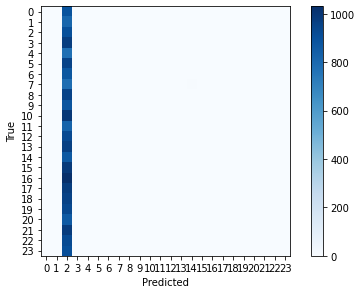

| Iteration 0 - Test Acc = 0.04

| Iteration 100 - Test Acc = 0.19| Iteration 200 - Test Acc = 0.27| Iteration 300 - Test Acc = 0.38| Iteration 400 - Test Acc = 0.39

| Iteration 500 - Test Acc = 0.40| Iteration 600 - Test Acc = 0.46| Iteration 700 - Test Acc = 0.50| Iteration 800 - Test Acc = 0.51

| Iteration 900 - Test Acc = 0.52| Iteration 1000 - Test Acc = 0.54| Iteration 1100 - Test Acc = 0.57| Iteration 1200 - Test Acc = 0.59

| Iteration 1300 - Test Acc = 0.59| Iteration 1400 - Test Acc = 0.60| Iteration 1500 - Test Acc = 0.61| Iteration 1600 - Test Acc = 0.63

| Iteration 1700 - Test Acc = 0.64| Iteration 1800 - Test Acc = 0.65| Iteration 1900 - Test Acc = 0.66| Iteration 2000 - Test Acc = 0.65

| Iteration 2100 - Test Acc = 0.68| Iteration 2200 - Test Acc = 0.67| Iteration 2300 - Test Acc = 0.68| Iteration 2400 - Test Acc = 0.67

| Iteration 2500 - Test Acc = 0.71| Iteration 2600 - Test Acc = 0.70| Iteration 2700 - Test Acc = 0.72| Iteration 2800 - Test Acc = 0.71

| Iteratio

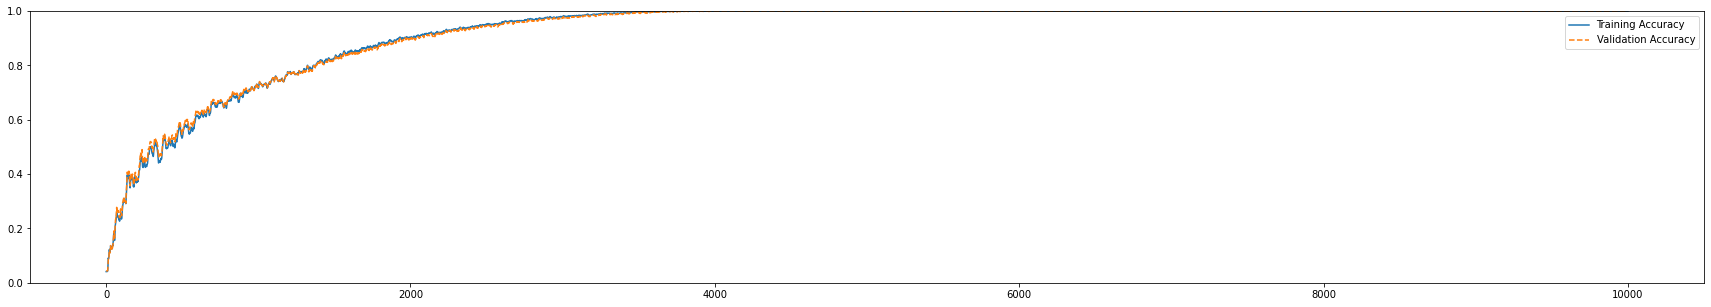

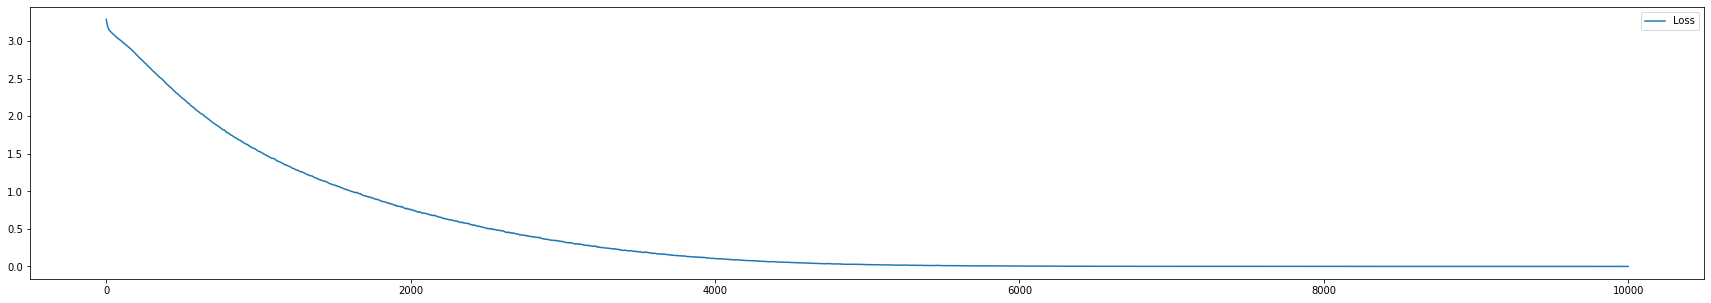

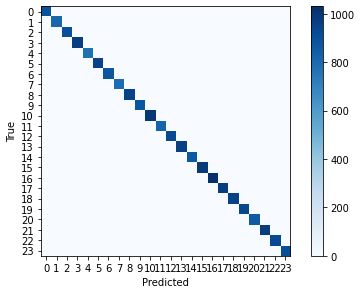

In [67]:
print_confusion_matrix()
num_iterations = 10000
[accs_train, accs_validation, loss] = optimize(num_iterations, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, '--', label='Validation Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), loss, label='Loss')
plt.legend()
plt.show()

print_confusion_matrix()

#### Exporting the Trained model

In [69]:
saver = tf.train.Saver()
saver.save(session, '/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_78pAcc')

'/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_78pAcc'

## Extra Works - Adding Rotated Images to the Training Set

I rotated all the images in the training set by +5 and -5 degrees for better performance

In [6]:
dataset_size = np.shape(x_train)[0]
np.append([[1, 2, 3], [4, 5, 6]], [[7, 8, 9]], axis=0)
print(np.shape(x_train))
print(np.shape(y_train_cls))
for i in range(0,dataset_size):
  image = x_train[i,:]
  rotated_pos = rotate(np.reshape(image, img_shape), angle=10, reshape=False)
  rotated_neg = rotate(np.reshape(image, img_shape), angle=-10, reshape=False)
  rotated_pos = np.reshape(rotated_pos, (1,img_size_flat))
  rotated_neg = np.reshape(rotated_neg, (1,img_size_flat))
  x_train = np.append(x_train, rotated_pos, axis=0)
  x_train = np.append(x_train, rotated_neg, axis=0)
  y_train_cls = np.append(y_train_cls, y_train_cls[i])
  y_train_cls = np.append(y_train_cls, y_train_cls[i])
print(np.shape(x_train))
print(np.shape(y_train_cls))

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()

(21964, 784)
(21964,)


KeyboardInterrupt: ignored

In [13]:
print(np.shape(x_train))
print(np.shape(y_train_cls))

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()
print(np.shape(y_train))

(54336, 784)
(54336,)
(54336, 24)


##### Network graph

In [26]:
tf.reset_default_graph()
beta1 = 0.85
beta2 = 0.92
learning_rate = 3e-5
batch_size = 200

hl1_n = int(2*img_size_flat)
hl2_n = int(2*img_size_flat)
hl3_n = int(img_size_flat)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_3 = tf.Variable(tf.random_normal([hl2_n, hl3_n],mean=0,stddev=1/np.sqrt(hl2_n)))
weights_out = tf.Variable(tf.random_normal([hl3_n, num_classes],mean=0,stddev=1/np.sqrt(hl3_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_3 = tf.Variable(tf.random_normal([hl3_n],mean=0,stddev=1/np.sqrt(hl3_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)




y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.sigmoid(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act)


y_2 = tf.matmul(y_1_act_DO, weights_2) + biases_2
y_2_act = tf.nn.sigmoid(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act)


y_3 = tf.matmul(y_2_act_DO, weights_3) + biases_3
y_3_act = tf.nn.sigmoid(y_3)
y_3_act_DO = tf.compat.v1.layers.dropout(y_3_act)

y_pred = tf.matmul(y_3_act_DO, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act_DO, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)
# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


##### Helper Functions

In [27]:
def optimize(num_iterations, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_iterations])
    accs_validation = np.zeros([num_iterations])
    # Test_Accuracy = np.zeros([num_iterations])
    loss = np.zeros([num_iterations])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    next_line = 0
    list_of_samples = [i for i in range(0, x_train.shape[0])]
    for i in range(num_iterations):
        if np.mod(i,100)==0:
          if np.mod(next_line,4) == 1:
            print('\n')
          Test_Accuracy = session.run(accuracy, feed_dict=feed_dict_test)
          next_line = next_line+1          
          print("| Iteration {0} - Test Acc = {1:.2f}".format(i, Test_Accuracy) , sep=' ', end='', flush=False)
        if len(list_of_samples) < batch_size:
          list_of_samples = [i for i in range(0, x_train.shape[0])]
        indexes = random.sample(list_of_samples, batch_size)
        for j in indexes:
          list_of_samples.remove(j)
        x_batch = x_train[indexes, :]
        y_true_batch = y_train[indexes]
        feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:0.5}

        session.run(optimizer, feed_dict=feed_dict) 
        [accs_train[i], loss[i]]= calcAccuracy(feed_dict_train)
        [accs_validation[i], loss[i]]= calcAccuracy(feed_dict_validation)
        # Test_Accuracy[i] = session.run(accuracy, feed_dict=feed_dict_test)
    return accs_train, accs_validation, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    axes.imshow(np.uint8(abs(w)), vmin=w_min, vmax=w_max, cmap='seismic')
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

def print_confusion_matrix():
    cls_true = feed_dict_test[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

##### Runing Optimization

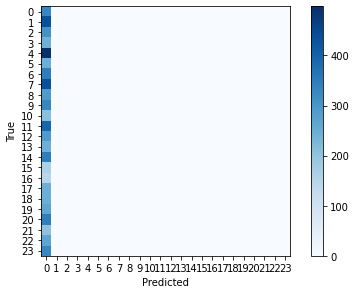

| Iteration 0 - Test Acc = 0.05

| Iteration 100 - Test Acc = 0.14| Iteration 200 - Test Acc = 0.23| Iteration 300 - Test Acc = 0.29| Iteration 400 - Test Acc = 0.33

| Iteration 500 - Test Acc = 0.36| Iteration 600 - Test Acc = 0.39| Iteration 700 - Test Acc = 0.46| Iteration 800 - Test Acc = 0.50

| Iteration 900 - Test Acc = 0.52| Iteration 1000 - Test Acc = 0.53| Iteration 1100 - Test Acc = 0.54| Iteration 1200 - Test Acc = 0.57

| Iteration 1300 - Test Acc = 0.60| Iteration 1400 - Test Acc = 0.59| Iteration 1500 - Test Acc = 0.62| Iteration 1600 - Test Acc = 0.62

| Iteration 1700 - Test Acc = 0.64| Iteration 1800 - Test Acc = 0.65| Iteration 1900 - Test Acc = 0.65| Iteration 2000 - Test Acc = 0.67

| Iteration 2100 - Test Acc = 0.67| Iteration 2200 - Test Acc = 0.67| Iteration 2300 - Test Acc = 0.68| Iteration 2400 - Test Acc = 0.68

| Iteration 2500 - Test Acc = 0.69| Iteration 2600 - Test Acc = 0.70| Iteration 2700 - Test Acc = 0.71| Iteration 2800 - Test Acc = 0.71

In [ ]:
print_confusion_matrix()
num_iterations = 5000
[accs_train, accs_validation, loss] = optimize(num_iterations, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_iterations, num_iterations), accs_validation, '--', label='Validation Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_iterations, num_iterations), loss, label='Loss')
plt.legend()
plt.show()

print_confusion_matrix()

#### Exporting the model

In [21]:
saver = tf.train.Saver()
saver.save(session, '/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_77pAcc')

'/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_77pAcc'